In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')

In [12]:
plt.rcParams['font.family'] = 'ONE Mobile'

In [3]:
# 22년도와 21년도 데이터
data_2022 = pd.read_csv('국민건강보험공단_건강검진정보_20221231.CSV')
data_2021 = pd.read_csv('국민건강보험공단_건강검진정보_20211231_수정.CSV')

# 병합
df = pd.concat([data_2022, data_2021], axis=0, join='inner', ignore_index=True)

In [4]:
# 데이터 정제를 위한 함수

def data_fixing(df):
    # 데이터를 알아보기 쉽게 변경. 코드 -> 문자열 
    sex = {1:'남자', 2:'여자'}
    df['성별'] = df['성별'].map(sex)

    # 20세 이상이 대상이므로 연령대 코드는 5부터 시작
    age = {5:'20~24세', 6:'25~29세', 7:'30~34세', 8:'35~39세', 
           9:'40~44세', 10:'45~49세', 11:'50~54세', 12:'55~59세', 13:'60~64세', 
           14:'65~69세', 15:'70~74세', 16:'75~79세', 17:'80~84세', 18:'85세+'}
    df['연령대코드(5세단위)'] = df['연령대코드(5세단위)'].map(age)

    region = {11:'서울특별시', 26:'부산광역시', 27:'대구광역시',  28:'인천광역시', 
              29:'광주광역시', 30:'대전광역시', 31:'울산광역시', 36:'세종특별자치시', 
              41:'경기도', 42:'강원도', 43:'충청북도', 44:'충청남도', 45:'전라북도', 
              46:'전라남도', 47:'경상북도', 48:'경상남도', 49:'제주특별자치도'}
    df['시도코드'] = df['시도코드'].map(region)

    smoke = {1:'비흡연자', 2:'이전에 피웠으나 끊었다', 3:'흡연자'}
    df['흡연상태'] = df['흡연상태'].map(smoke)

    drunk = {0:'마시지 않는다', 1:'마신다'}
    df['음주여부'] = df['음주여부'].map(drunk)
    
    # 열 이름 변경
    df.rename(columns={'시도코드':'지역', '연령대코드(5세단위)':'연령대', '신장(5cm단위)':'신장', 
                   '체중(5kg단위)':'체중', '수축기혈압':'최고혈압', '이완기혈압':'최저혈압'}, inplace=True)
    
    # 필요없는 열 제거
    df_del_col = df.drop(['가입자일련번호', '시력(좌)', '시력(우)', '청력(좌)', '청력(우)', '총콜레스테롤',
                      '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', '요단백', '혈청크레아티닌',
                      '구강검진수검여부', '치아우식증유무', '치석'], axis=1)
    
    # 흡연상태 열에서 이전에 피웠던 사람들을 흡연자로 변경
    df_del_col = df_del_col.replace({'흡연상태': '이전에 피웠으나 끊었다'}, '흡연자')
    
    # 결측치 처리
    df_del_row = df_del_col.dropna().reset_index(drop=True)
    
    # BMI와 비만분류 열 추가
    def bmi_col(df):
        if df < 18.5:
            return '저체중'
        elif (df >= 18.5) & (df < 23):
            return '정상'
        elif (df >= 23) & (df < 25):
            return '과체중'
        elif (df >= 25) & (df < 30):
            return '1단계 비만'
        elif (df >= 30) & (df < 35):
            return '2단계 비만'
        elif df >= 35:
            return '3단계 비만'
        
    df_del_row['BMI'] = round(df_del_row['체중'] / ((df_del_row['신장'] /100)**2), 2)
    df_del_row['비만분류'] = df_del_row['BMI'].apply(bmi_col)
    
    return df_del_row

In [5]:
df = data_fixing(df)

## 부록(1) 흡연상태, 음주여부에 따른 BMI 분포

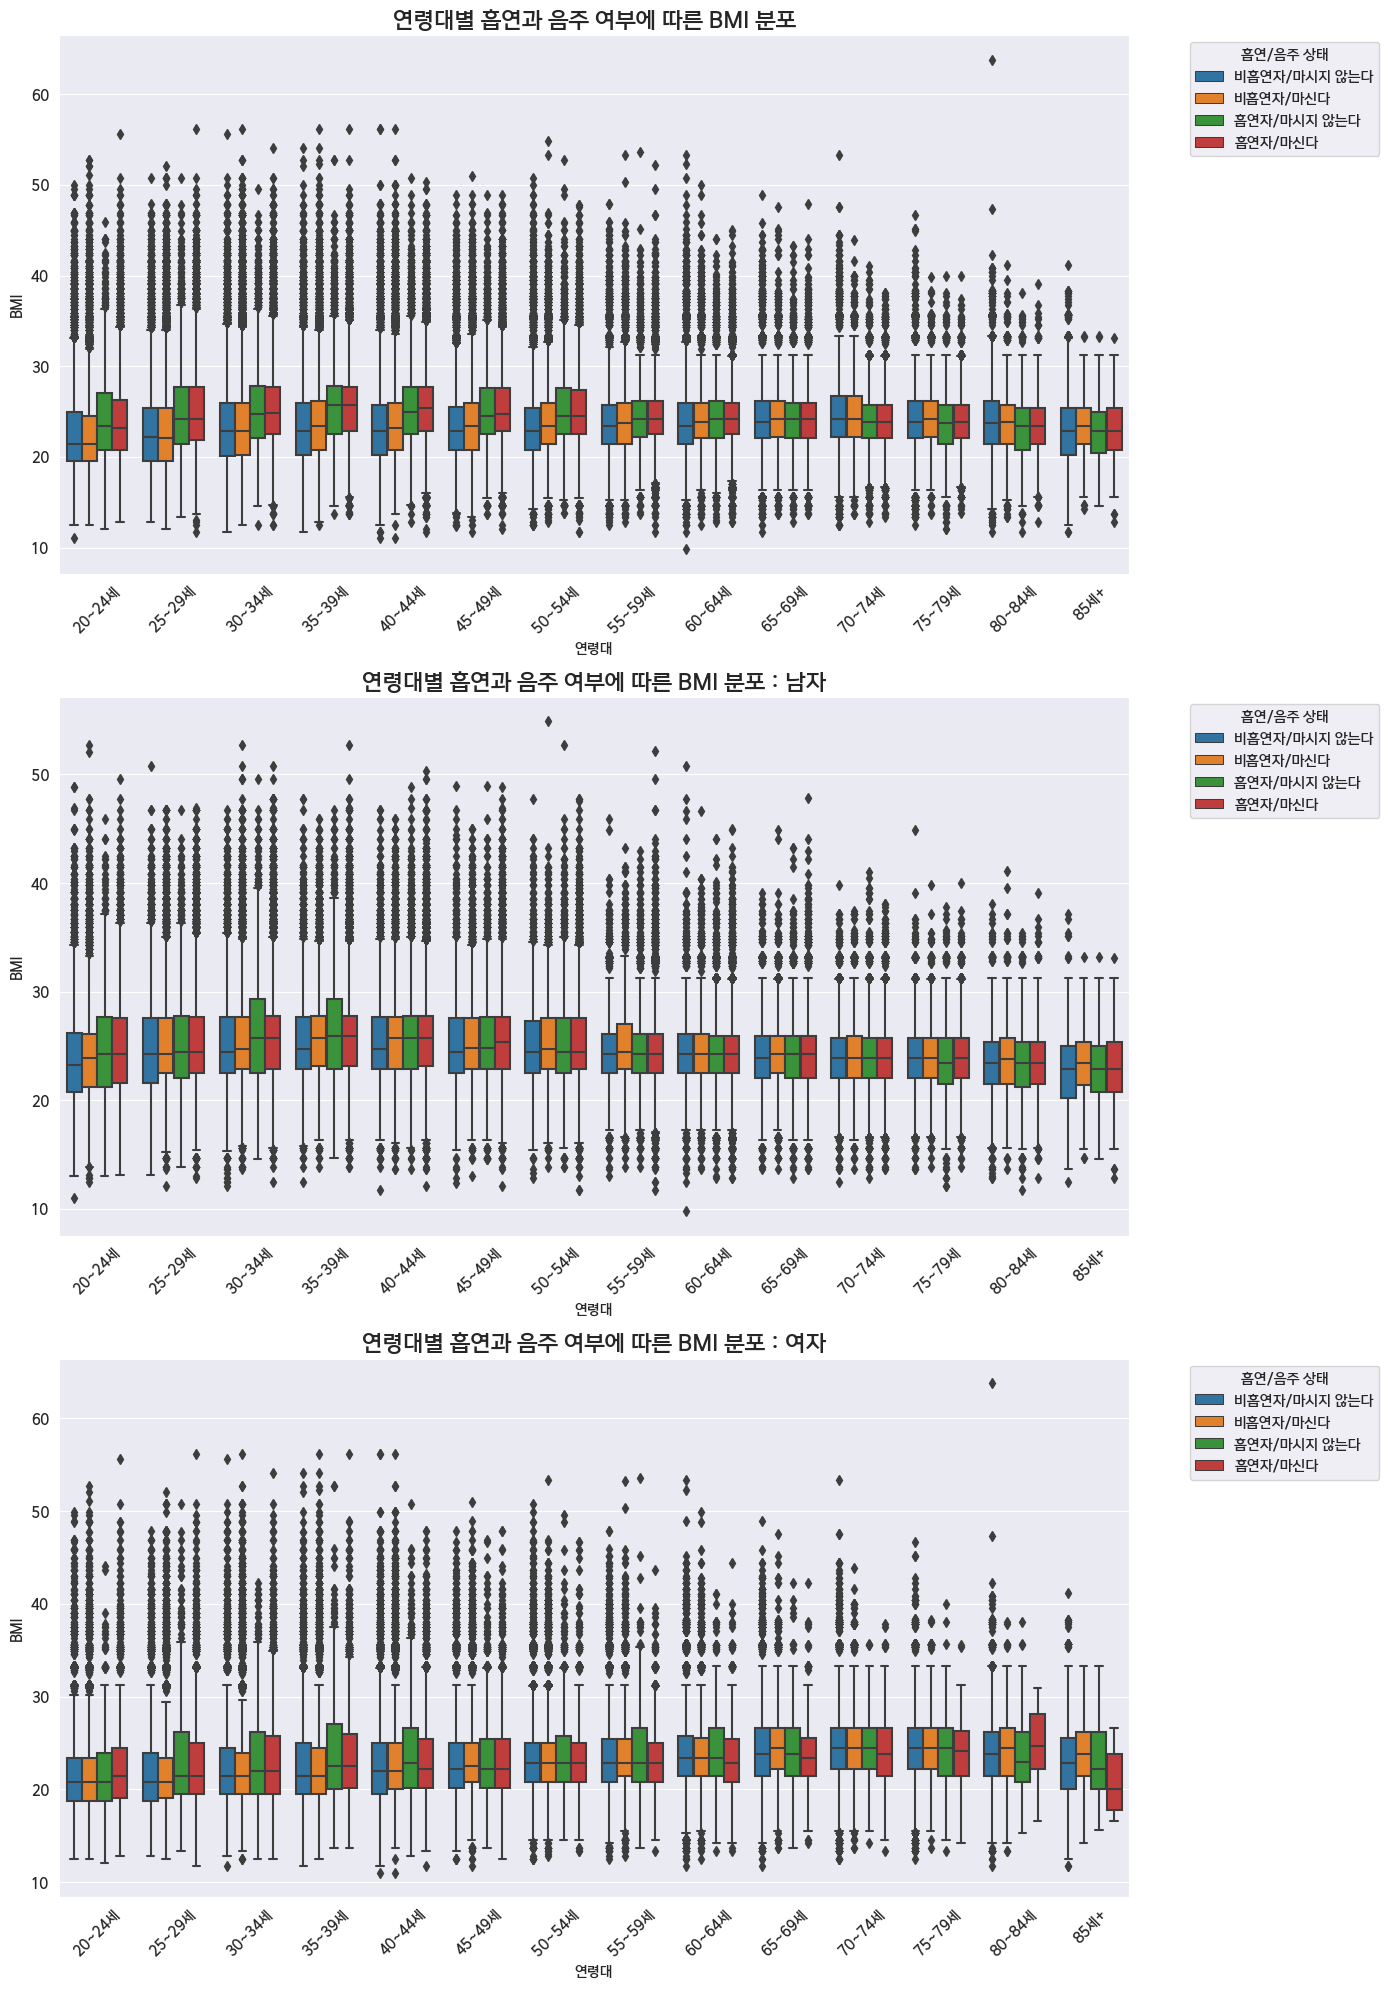

In [13]:
df_smoke_drunk = df.sort_values(['연령대', '흡연상태', '음주여부'])
df_smoke_drunk['흡연_음주'] = df_smoke_drunk.apply(lambda row: f"{row['흡연상태']}/{row['음주여부']}", axis=1)

mdf_smoke_drunk = df.sort_values(['연령대', '흡연상태', '음주여부']).loc[df['성별']=='남자']
mdf_smoke_drunk['흡연_음주'] = df_smoke_drunk.apply(lambda row: f"{row['흡연상태']}/{row['음주여부']}", axis=1)

fdf_smoke_drunk = df.sort_values(['연령대', '흡연상태', '음주여부']).loc[df['성별']=='여자']
fdf_smoke_drunk['흡연_음주'] = df_smoke_drunk.apply(lambda row: f"{row['흡연상태']}/{row['음주여부']}", axis=1)


plt.figure(figsize=(14, 20))

plt.subplot(311)
sns.boxplot(x='연령대', y='BMI', hue='흡연_음주', data=df_smoke_drunk)
plt.title('연령대별 흡연과 음주 여부에 따른 BMI 분포', fontsize=16)
plt.legend(title='흡연/음주 상태', bbox_to_anchor=(1.05, 1), loc=2)
plt.xticks(rotation=45)

plt.subplot(312)
sns.boxplot(x='연령대', y='BMI', hue='흡연_음주', data=mdf_smoke_drunk)
plt.title('연령대별 흡연과 음주 여부에 따른 BMI 분포 : 남자', fontsize=16)
plt.legend(title='흡연/음주 상태', bbox_to_anchor=(1.05, 1), loc=2)
plt.xticks(rotation=45)


plt.subplot(313)
sns.boxplot(x='연령대', y='BMI', hue='흡연_음주', data=fdf_smoke_drunk)
plt.title('연령대별 흡연과 음주 여부에 따른 BMI 분포 : 여자', fontsize=16)
plt.legend(title='흡연/음주 상태', bbox_to_anchor=(1.05, 1), loc=2)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 부록(2) 데이터 샘플링 1

연령별로 1000명씩 남자 14000명, 여자 14000명을 랜덤하게 추출

In [14]:
# 남자와 여자로 데이터 분리
male_data = df[df['성별'] == '남자']
female_data = df[df['성별'] == '여자']

# 연령대 리스트 생성
age_list = df['연령대'].unique()

# 남녀1000명씩 추출할 데이터프레임
sampled_male = pd.DataFrame()
sampled_female = pd.DataFrame()

# 연령대별로 1000명씩 추출
for age in age_list:
    male_sample = male_data[male_data['연령대'] == age].sample(n=1000, random_state=42)
    female_sample = female_data[female_data['연령대'] == age].sample(n=1000, random_state=42)
    sampled_male = pd.concat([sampled_male, male_sample])
    sampled_female = pd.concat([sampled_female, female_sample])

concat_sample = pd.concat([sampled_male, sampled_female]).reset_index(drop=True)

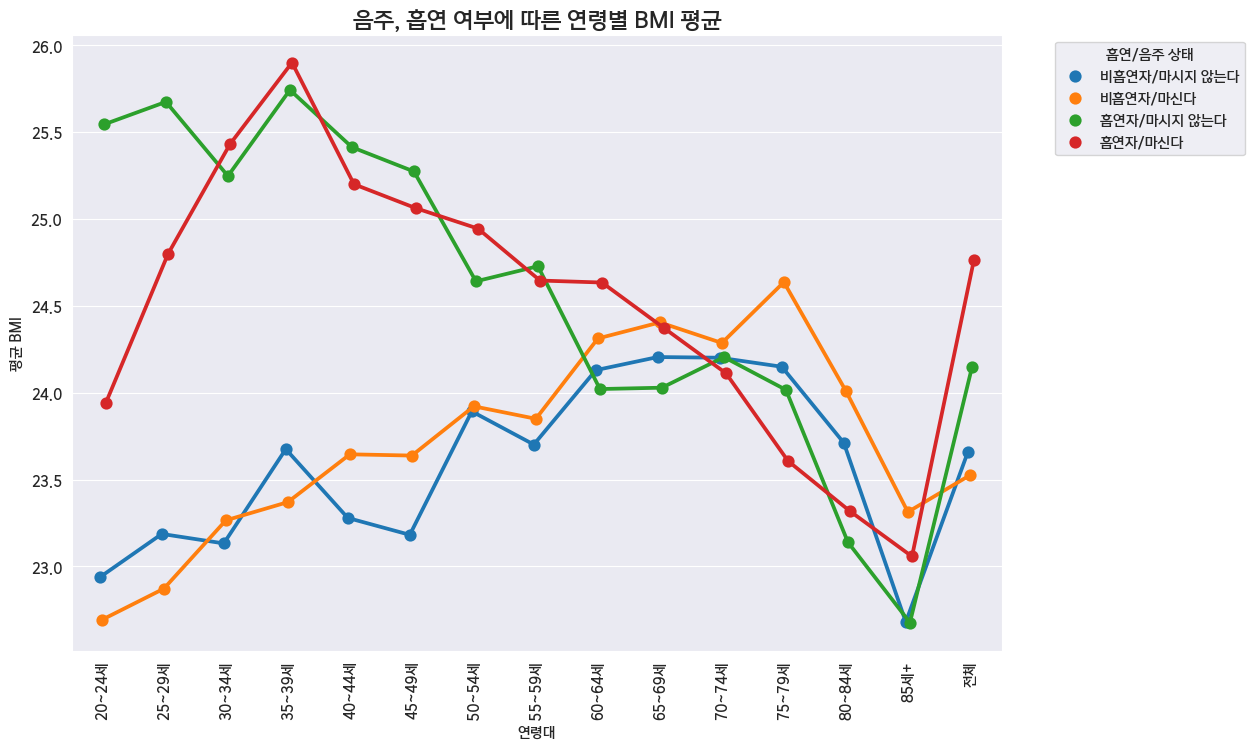

In [17]:
total = concat_sample.groupby(['흡연상태', '음주여부']).mean()['BMI'].reset_index()
sp_mean_both = concat_sample.groupby(['연령대', '흡연상태', '음주여부']).mean()['BMI'].reset_index()
for i in range(4):
    sp_mean_both.loc[56 + i] = ['전체', total['흡연상태'][i], total['음주여부'][i], total['BMI'][i]]
    
sp_mean_both['흡연_음주'] = sp_mean_both.apply(lambda row: f"{row['흡연상태']}/{row['음주여부']}", axis=1)
sp_mean_both.drop(['흡연상태', '음주여부'], axis=1, inplace=True)

# 연령대별 + 전체 흡연상태와 음주여부에 따른 BMI 평균 그래프
plt.figure(figsize=(12, 8))
plt.title('음주, 흡연 여부에 따른 연령별 BMI 평균', fontsize=16)
sns.pointplot(x='연령대', y='BMI', hue='흡연_음주', data=sp_mean_both, dodge=True, capsize=.1)
plt.xlabel('연령대')
plt.ylabel('평균 BMI')
plt.legend(title='흡연/음주 상태', bbox_to_anchor=(1.05, 1), loc=2)
plt.xticks(rotation='vertical')
plt.show()

## 부록(3) 데이터 샘플링 2

남녀의 흡연자, 비흡연자 수를 맞추는 샘플링

In [21]:
# 남자와 여자로 데이터 분리
male_data = df[df['성별'] == '남자']
female_data = df[df['성별'] == '여자']

# 연령대 리스트 생성
age_list = df['연령대'].unique()

# 남자와 여자 연령대 별로 추출할 데이터프레임 생성
sampled_male = pd.DataFrame()
sampled_female = pd.DataFrame()

# 연령대별로 샘플링
for age in age_list:
    male_age_data = male_data[male_data['연령대'] == age]
    female_age_data = female_data[female_data['연령대'] == age]
    
    # 흡연자와 비흡연자 수를 비슷하게 맞추기 위해 남녀 최소 데이터 개수 저장
    num_male_smoke = len(male_age_data[male_age_data['흡연상태'] == '흡연자'])
    num_female_smoke = len(female_age_data[female_age_data['흡연상태'] == '흡연자'])
    min_smoke = min(num_male_smoke, num_female_smoke)

    num_male_no_smoke = len(male_age_data[male_age_data['흡연상태'] == '비흡연자'])
    num_female_no_smoke = len(female_age_data[female_age_data['흡연상태'] == '비흡연자'])
    min_no_smoke = min(num_male_no_smoke, num_female_no_smoke)
    
    # 최소 데이터 개수에 맞춰 샘플링
    male_sample = pd.concat([
        male_age_data[(male_age_data['흡연상태'] == '흡연자')].sample(n=min_smoke, random_state=42),
        male_age_data[(male_age_data['흡연상태'] == '비흡연자')].sample(n=min_no_smoke, random_state=42)
    ])
    
    female_sample = pd.concat([
        female_age_data[(female_age_data['흡연상태'] == '흡연자')].sample(n=min_smoke, random_state=42),
        female_age_data[(female_age_data['흡연상태'] == '비흡연자')].sample(n=min_no_smoke, random_state=42)
    ])
    
    # 샘플링한 데이터 병합
    sampled_male = pd.concat([sampled_male, male_sample])
    sampled_female = pd.concat([sampled_female, female_sample])

# 데이터 병합
df_sample = pd.concat([sampled_male, sampled_female]).reset_index(drop=True)

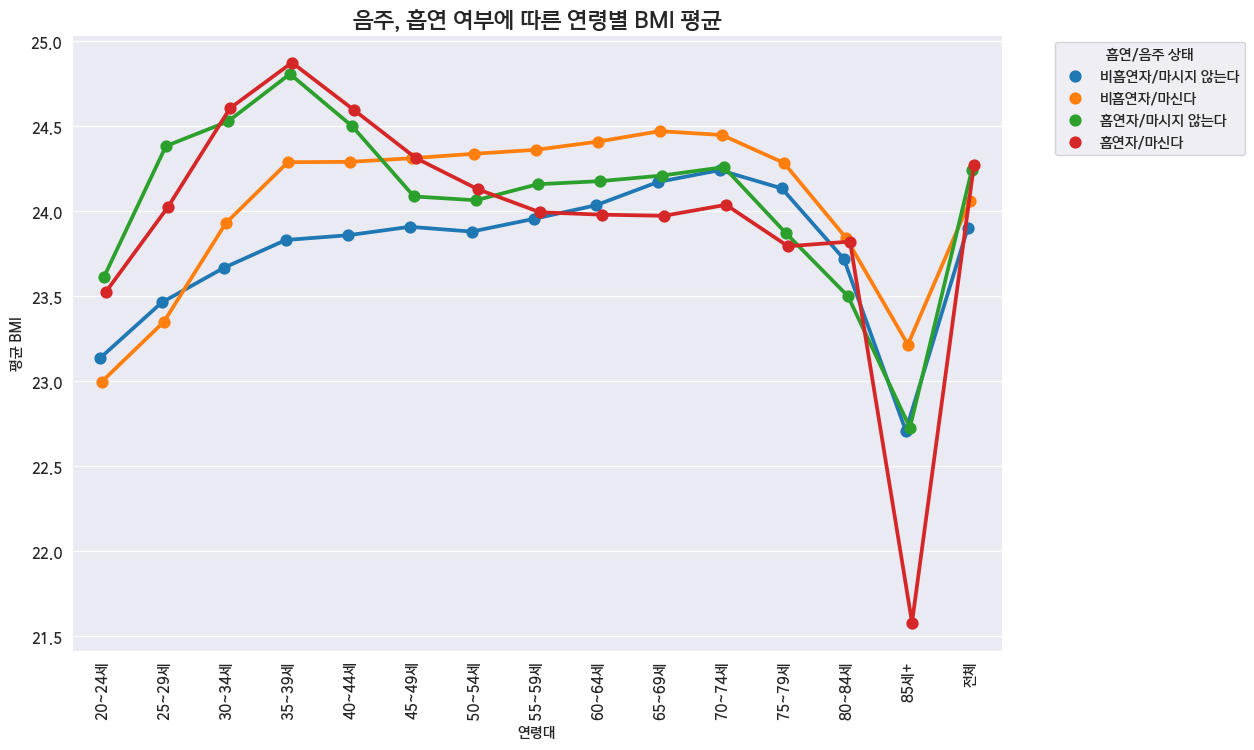

In [22]:
total = df_sample.groupby(['흡연상태', '음주여부']).mean()['BMI'].reset_index()
sp_mean_both = df_sample.groupby(['연령대', '흡연상태', '음주여부']).mean()['BMI'].reset_index()
for i in range(4):
    sp_mean_both.loc[56 + i] = ['전체', total['흡연상태'][i], total['음주여부'][i], total['BMI'][i]]
    
sp_mean_both['흡연_음주'] = sp_mean_both.apply(lambda row: f"{row['흡연상태']}/{row['음주여부']}", axis=1)
sp_mean_both.drop(['흡연상태', '음주여부'], axis=1, inplace=True)

# 연령대별 + 전체 흡연상태와 음주여부에 따른 BMI 평균 그래프
plt.figure(figsize=(12, 8))
plt.title('음주, 흡연 여부에 따른 연령별 BMI 평균', fontsize=16)
sns.pointplot(x='연령대', y='BMI', hue='흡연_음주', data=sp_mean_both, dodge=True, capsize=.1)
plt.xlabel('연령대')
plt.ylabel('평균 BMI')
plt.legend(title='흡연/음주 상태', bbox_to_anchor=(1.05, 1), loc=2)
plt.xticks(rotation='vertical')
plt.show()

## 부록(4) 전체 비만분류 비율

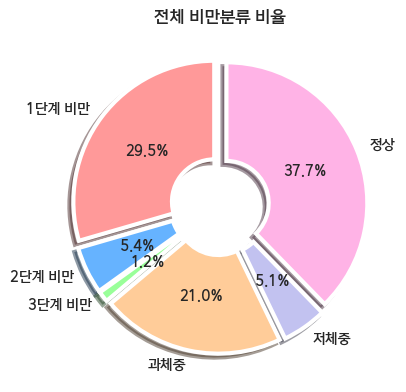

In [27]:
df_obe = df.groupby(['비만분류']).size().reset_index(name=('인원수(명)'))

plt.figure(figsize=(10, 8))

plt.subplot(121)
plt.pie(df_obe['인원수(명)'].values,
        labels=df_obe['비만분류'].values, 
        autopct='%.1f%%',
        startangle=90,
        explode=[0.05,0.05,0.05,0.05,0.05,0.05],
        shadow=True,
        colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0','#ffb3e6'],
        wedgeprops = {'width':0.7,'edgecolor':'w','linewidth':3}
       )
plt.title('전체 비만분류 비율')

plt.show()